In [4]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
ROOT.gROOT.ProcessLine("gErrorIgnoreLevel = 3001;"); # suppress ROOT messages
ROOT.disableJSVis()
ROOT.gStyle.SetOptStat(0)
# ROOT.gROOT.ProcessLine(".x ~/env/MJDClintPlotStyle.C");

dsBcMax = [826,642,658,578,770] # cdf method

# results:
# DS0: 
# raw 01: 0.323  05: 0.367  10: 0.393 15: 0.408  90: 0.637  95: 0.688  99: 0.782
# bg 01: 0.418  05: 0.458  10: 0.478 15: 0.492  90: 0.792  95: 0.833  99: 0.887
# ext 01: 0.443  05: 0.487  10: 0.507 15: 0.522  90: 0.642  95: 0.657  99: 0.682
# DS1: 
# raw 01: 0.003  05: 0.348  10: 0.453 15: 0.497  90: 0.812  95: 0.872  99: 0.953
# bg 01: 0.487  05: 0.637  10: 0.688 15: 0.742  90: 0.967  95: 0.987  99: 1.018
# DS2: none yet
# DS3: 
# raw 01: 0.278  05: 0.422  10: 0.473 15: 0.502  90: 0.797  95: 0.852  99: 0.938
# bg 01: 0.492  05: 0.537  10: 0.557 15: 0.573  90: 0.927  95: 0.948  99: 0.992
# DS4: 
# raw 01: 0.367  05: 0.478  10: 0.522 15: 0.552  90: 0.872  95: 0.917  99: 0.987
# bg 01: -0.003  05: 0.582  10: 0.698 15: 0.757  90: 0.943  95: 0.953  99: 0.972
# DS5: 
# raw 01: 0.307  05: 0.378  10: 0.418 15: 0.448  90: 0.767  95: 0.828  99: 0.912
# bg 01: 0.208  05: 0.283  10: 0.328 15: 0.367  90: 0.812  95: 0.847  99: 0.902

def npTH1D(hist):
    bins = hist.GetNbinsX()
    xArr, yArr = np.zeros(bins),np.zeros(bins)
    for i in range(bins): 
        xArr[i] = hist.GetXaxis().GetBinCenter(i)
        yArr[i] = hist.GetBinContent(i)    
    return xArr,yArr

def integFunc(arr):
    integ = np.zeros(len(arr))
    sum = 0
    for i in range(0,len(arr)):
        sum+=arr[i]
        integ[i] = sum
    return integ

def GetIntegralPoints(hist):
    x_h0, y_h0 = npTH1D(hist)
    int_h0 = integFunc(y_h0)
    
    idx99 = np.where(int_h0 > 0.99)
    idx95 = np.where(int_h0 > 0.95)
    idx90 = np.where(int_h0 > 0.90)
    idx01 = np.where(int_h0 > 0.01)
    idx05 = np.where(int_h0 > 0.05)
    idx10 = np.where(int_h0 > 0.10)
    idx15 = np.where(int_h0 > 0.15)
    
    val99 = x_h0[idx99][0]
    val95 = x_h0[idx95][0]
    val90 = x_h0[idx90][0]
    val01 = x_h0[idx01][0]
    val05 = x_h0[idx05][0]
    val10 = x_h0[idx10][0]
    val15 = x_h0[idx15][0]
    return val01,val05,val10,val15,val90,val95,val99

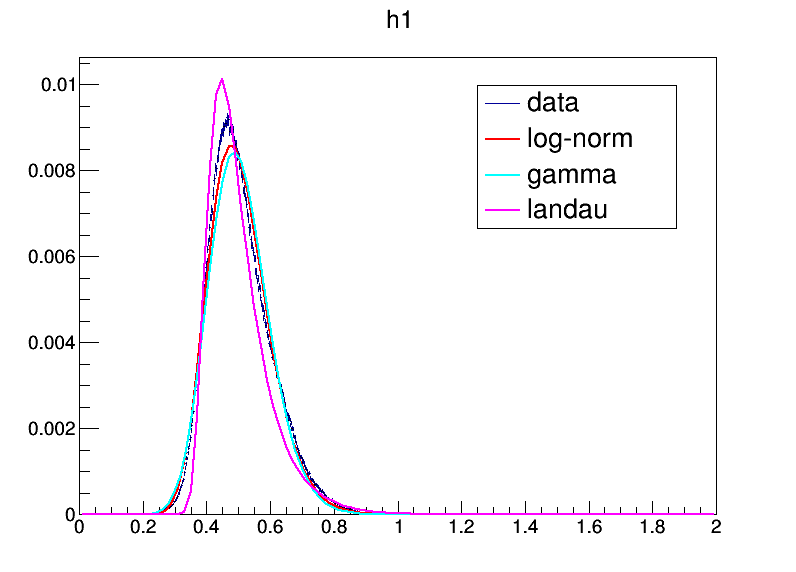

In [5]:
# The moral of the story:  NONE of the methods really fit this very well.
# It could be from going down to 5 kev and having the spectrum get distorted.
# I like the direct integral method.

ds = 0
f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
ExtCut = "channel == 624"
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)
Ext = ROOT.TChain("mjdTree"); Ext.Add("~/project/ForceTrigger/lat_run72*.root")

c1 = ROOT.TCanvas("c1","c1",800,600)

h1 = ROOT.TH1D("h1","h1",1000,0,2)
calib.Project("h1","(waveS4-waveS1)/bcMax/trapENFCal",theCut+"&& trapENFCal > 5")
h1.Scale(1/h1.Integral())
h1.Draw()

# # log-normal (probably the closest)
f2 = ROOT.TF1("f2","([0]/x) * exp(-1.0 * (log(x) - [1])**2 / 2 * [2]**2)",0,5)
f2.SetParameter(0,1e-3)
f2.SetParameter(1,-0.1)
f2.SetParameter(2,5)
f2.SetLineColor(ROOT.kRed)
h1.Fit("f2","q")
f2.Draw("same")

# gamma
f3 = ROOT.TF1("f3","([0]/(TMath::Gamma([1]) * [2]**[1])) * x**([1]-1) * exp((-1 * x)/[2])",0.1,5)
f3.SetParameter(0,0.0018)
f3.SetParameter(1,30)
f3.SetParameter(2,0.015)
f3.SetLineColor(ROOT.kCyan)
h1.Fit("f3","q")
f3.Draw("same")

# modified landau from wiki page
f4 = ROOT.TF1("f4","([0]/sqrt(2*pi)) * exp(-0.5 * ((x-[1])/[2] + exp(-(x-[1])/[2]) ))",0,5) 
f4.SetParameter(0,0.04)
f4.SetParameter(1,0.45)
f4.SetParameter(2,0.05)
f4.SetLineColor(ROOT.kMagenta)
h1.Fit("f4","q")
f4.Draw("same")

l1 = ROOT.TLegend(0.6,0.6,0.85,0.85)
l1.AddEntry(h1,"data","l")
# l1.AddEntry(f1,"gaus","l")
l1.AddEntry(f2,"log-norm","l")
l1.AddEntry(f3,"gamma","l")
l1.AddEntry(f4,"landau","l")
l1.Draw("same")

c1.Draw()

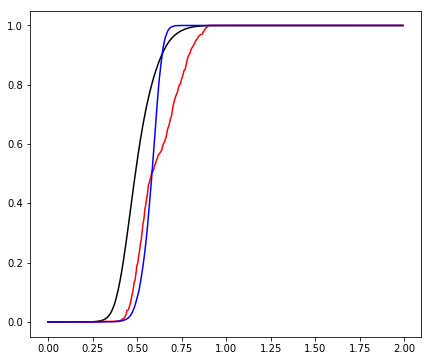

raw 01: 0.323  05: 0.367  10: 0.393 15: 0.408  90: 0.637  95: 0.688  99: 0.782
bg 01: 0.418  05: 0.458  10: 0.478 15: 0.492  90: 0.792  95: 0.833  99: 0.887
ext 01: 0.443  05: 0.487  10: 0.507 15: 0.522  90: 0.642  95: 0.657  99: 0.682


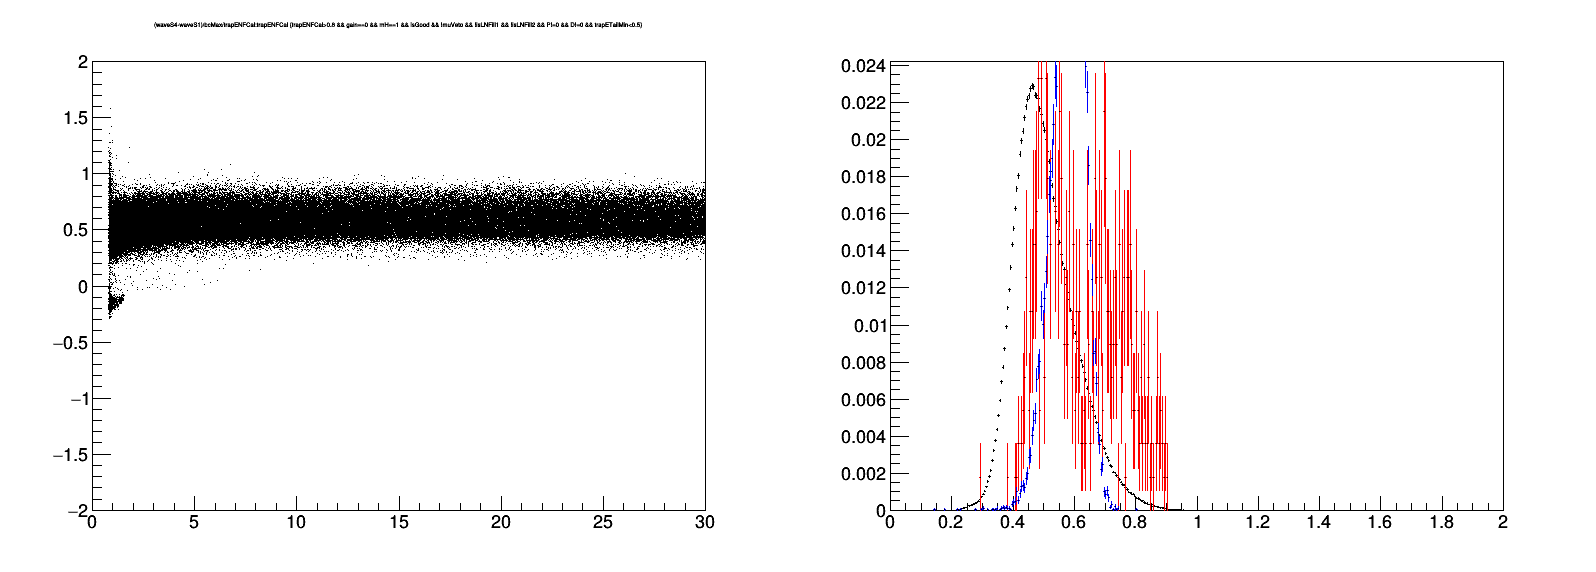

In [6]:
# This compares noiseWeight with and without the bcMax cut.
# The later cells don't bother applying the bcMax cut. 
# (This one shows it doesn't make a big difference in the suggested cut values.)

ds = 0
bins, lower, upper = 400,0.,2

c = ROOT.TCanvas("c","c",1600,600)
c.Divide(2,1)
c.cd(1); ROOT.gPad.SetLogy(0)
calib.Draw("(waveS4-waveS1)/bcMax/trapENFCal:trapENFCal>>h1(10,0,30,10,-2,2)",theCut)
c.cd(2); ROOT.gPad.SetLogy(0)
h0 = ROOT.TH1D("h0","",bins,lower,upper)
calib.Project("h0","(waveS4-waveS1)/bcMax/trapENFCal",theCut+"&&trapENFCal>5")
h01 = ROOT.TH1D("h01","",bins,lower,upper)
bg.Project("h01","(waveS4-waveS1)/bcMax/trapENFCal",theCut+bgCut)
h02 = ROOT.TH1D("h02","",bins,lower,upper)
Ext.Project("h02","(waveS4-waveS1)/bcMax/trapENFCal",ExtCut)
h0.Scale(1./h0.Integral()); h0.SetLineColor(ROOT.kBlack); h0.Draw()
h01.Scale(1./h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
h02.Scale(1./h02.Integral()); h02.SetLineColor(ROOT.kBlue); h02.Draw("SAME")
c.Draw()

# Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
ext01,ext05,ext10,ext15,ext90,ext95,ext99 = GetIntegralPoints(h02)
print "raw 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (raw01,raw05,raw10,raw15,raw90,raw95,raw99)
print "bg 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (bg01,bg05,bg10,bg15,bg90,bg95,bg99)
print "ext 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (ext01,ext05,ext10,ext15,ext90,ext95,ext99)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'black')
x1_h0, y1_h0 = npTH1D(h01)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
x2_h0, y2_h0 = npTH1D(h02)
int2_h0 = integFunc(y2_h0)
plt.plot(x2_h0,int2_h0,'blue')
# plt.axvline(raw95,color='red')
# plt.axvline(raw99,color='green')
# plt.axvline(raw01,color='green')
# plt.axvline(raw05,color='red')
plt.show()

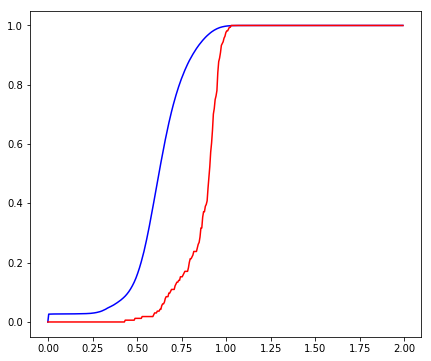

raw 01: 0.003  05: 0.348  10: 0.453 15: 0.497  90: 0.812  95: 0.872  99: 0.953
bg 01: 0.487  05: 0.637  10: 0.688 15: 0.742  90: 0.967  95: 0.987  99: 1.018


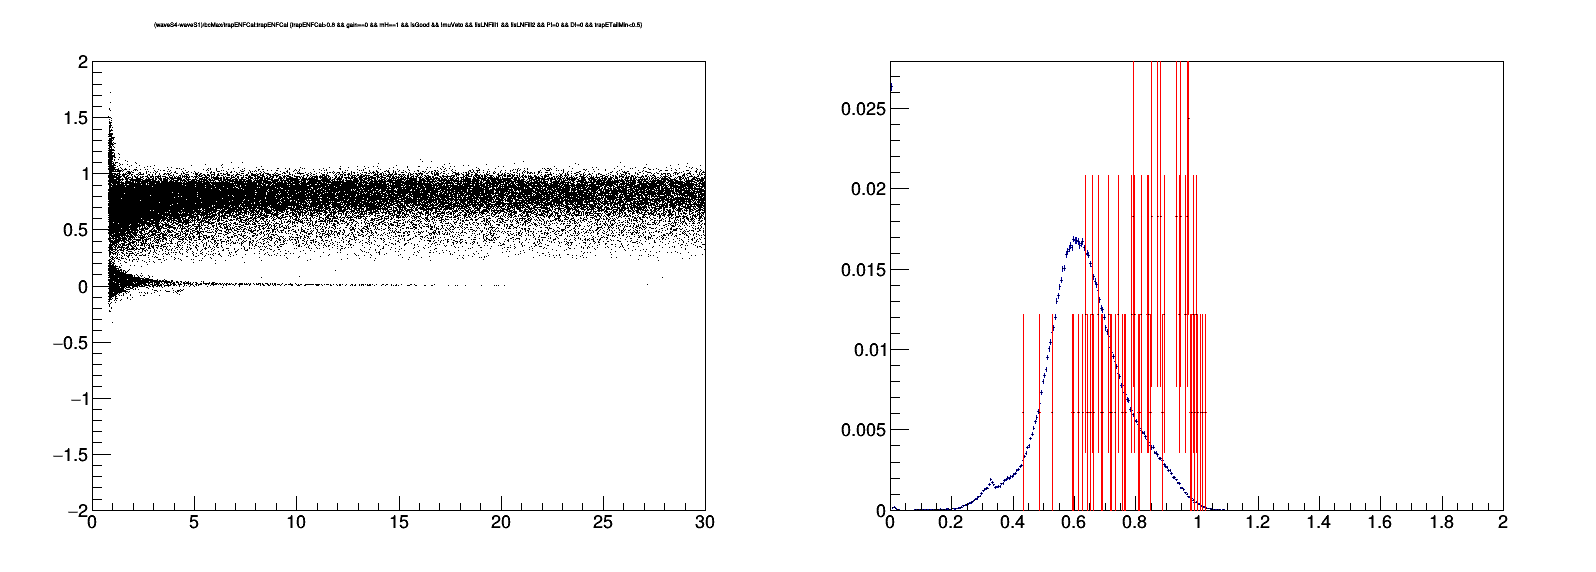

In [7]:
ds = 1
bins, lower, upper = 400,0,2
f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)
c = ROOT.TCanvas("c","c",1600,600)
c.Divide(2,1)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
calib.Draw("(waveS4-waveS1)/bcMax/trapENFCal:trapENFCal>>h1(10,0,30,10,-2,2)",theCut)

c.cd(2)
ROOT.gPad.SetLogy(0)

h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
calib.Project("h0","(waveS4-waveS1)/bcMax/trapENFCal",theCut+"&& trapENFCal > 5")
bg.Project("h01","(waveS4-waveS1)/bcMax/trapENFCal",theCut+bgCut)
h0.Scale(1/h0.Integral()); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
c.Draw()

# Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
print "raw 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (raw01,raw05,raw10,raw15,raw90,raw95,raw99)
print "bg 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (bg01,bg05,bg10,bg15,bg90,bg95,bg99)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'b')
x1_h0, y1_h0 = npTH1D(h01)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
# plt.axvline(raw95,color='red')
# plt.axvline(raw99,color='green')
# plt.axvline(raw01,color='green')
# plt.axvline(raw05,color='red')
plt.show()

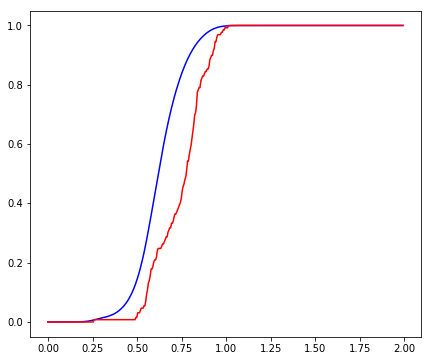

raw 01: 0.278  05: 0.422  10: 0.473 15: 0.502  90: 0.797  95: 0.852  99: 0.938
bg 01: 0.492  05: 0.537  10: 0.557 15: 0.573  90: 0.927  95: 0.948  99: 0.992


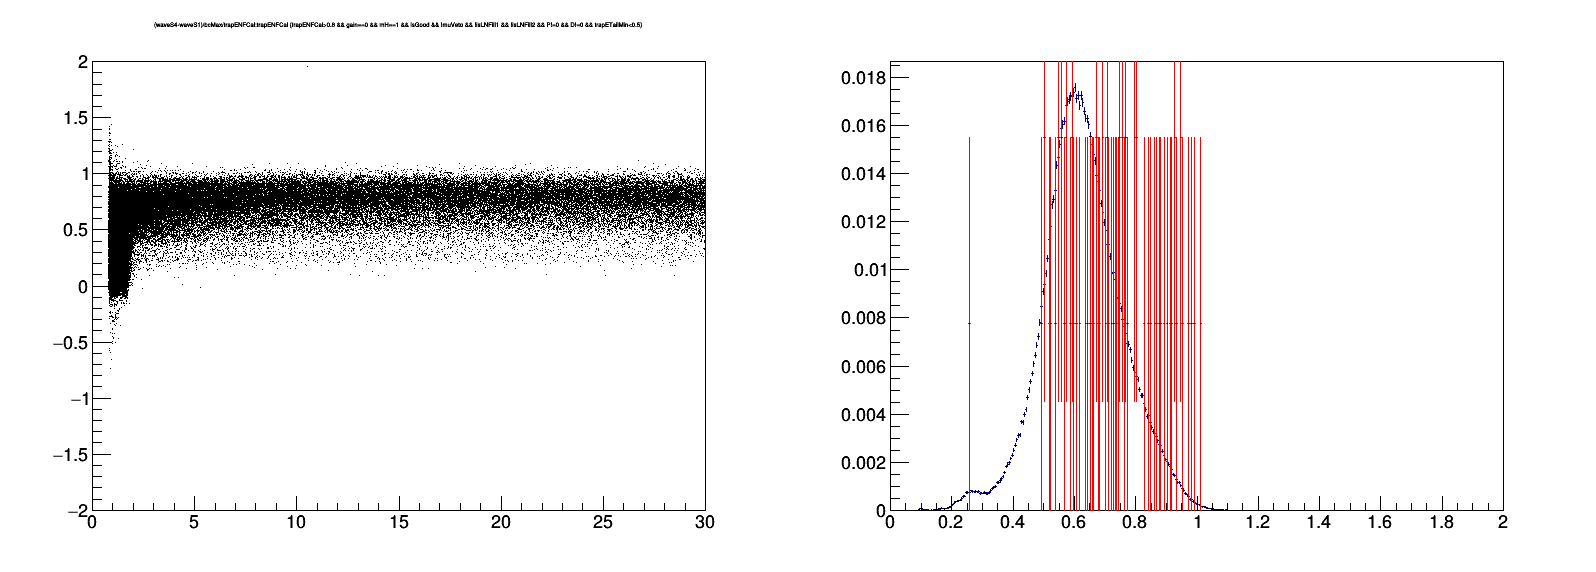

In [8]:
ds = 3
bins, lower, upper = 400,0,2
f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)
c = ROOT.TCanvas("c","c",1600,600)
c.Divide(2,1)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
calib.Draw("(waveS4-waveS1)/bcMax/trapENFCal:trapENFCal>>h1(10,0,30,10,-2,2)",theCut)

c.cd(2)
ROOT.gPad.SetLogy(0)

h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
calib.Project("h0","(waveS4-waveS1)/bcMax/trapENFCal",theCut+"&& trapENFCal > 5")
bg.Project("h01","(waveS4-waveS1)/bcMax/trapENFCal",theCut+bgCut)
h0.Scale(1/h0.Integral()); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
c.Draw()

# Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
print "raw 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (raw01,raw05,raw10,raw15,raw90,raw95,raw99)
print "bg 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (bg01,bg05,bg10,bg15,bg90,bg95,bg99)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'b')
x1_h0, y1_h0 = npTH1D(h01)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
# plt.axvline(raw95,color='red')
# plt.axvline(raw99,color='green')
# plt.axvline(raw01,color='green')
# plt.axvline(raw05,color='red')
plt.show()

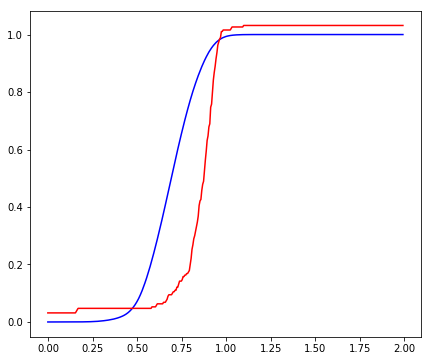

raw 01: 0.367  05: 0.478  10: 0.522 15: 0.552  90: 0.872  95: 0.917  99: 0.987
bg 01: -0.003  05: 0.582  10: 0.698 15: 0.757  90: 0.943  95: 0.953  99: 0.972


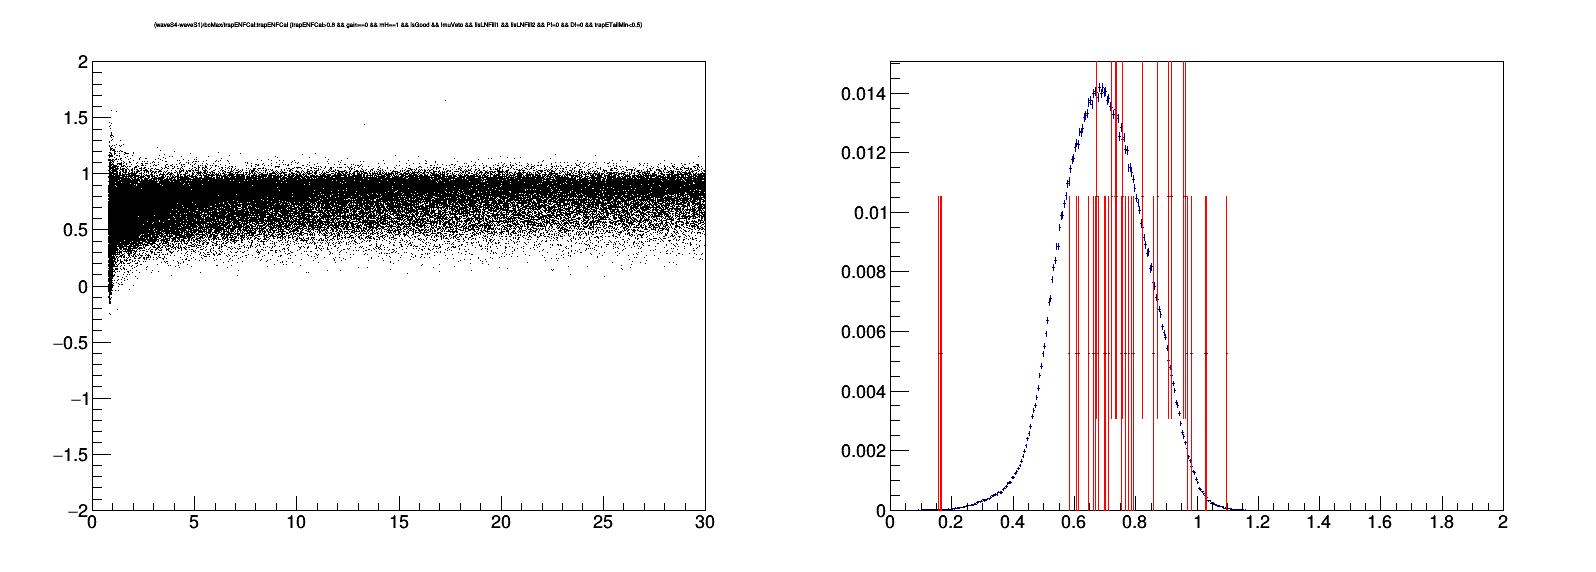

In [9]:
ds = 4
bins, lower, upper = 400,0,2
f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)
c = ROOT.TCanvas("c","c",1600,600)
c.Divide(2,1)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
calib.Draw("(waveS4-waveS1)/bcMax/trapENFCal:trapENFCal>>h1(10,0,30,10,-2,2)",theCut)

c.cd(2)
ROOT.gPad.SetLogy(0)

h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
calib.Project("h0","(waveS4-waveS1)/bcMax/trapENFCal",theCut+"&& trapENFCal > 5")
bg.Project("h01","(waveS4-waveS1)/bcMax/trapENFCal",theCut+bgCut)
h0.Scale(1/h0.Integral()); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
c.Draw()

# Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
print "raw 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (raw01,raw05,raw10,raw15,raw90,raw95,raw99)
print "bg 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (bg01,bg05,bg10,bg15,bg90,bg95,bg99)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'b')
x1_h0, y1_h0 = npTH1D(h01)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
# plt.axvline(raw95,color='red')
# plt.axvline(raw99,color='green')
# plt.axvline(raw01,color='green')
# plt.axvline(raw05,color='red')
plt.show()

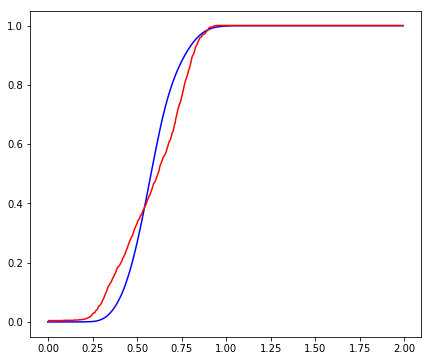

raw 01: 0.307  05: 0.378  10: 0.418 15: 0.448  90: 0.767  95: 0.828  99: 0.912
bg 01: 0.208  05: 0.283  10: 0.328 15: 0.367  90: 0.812  95: 0.847  99: 0.902


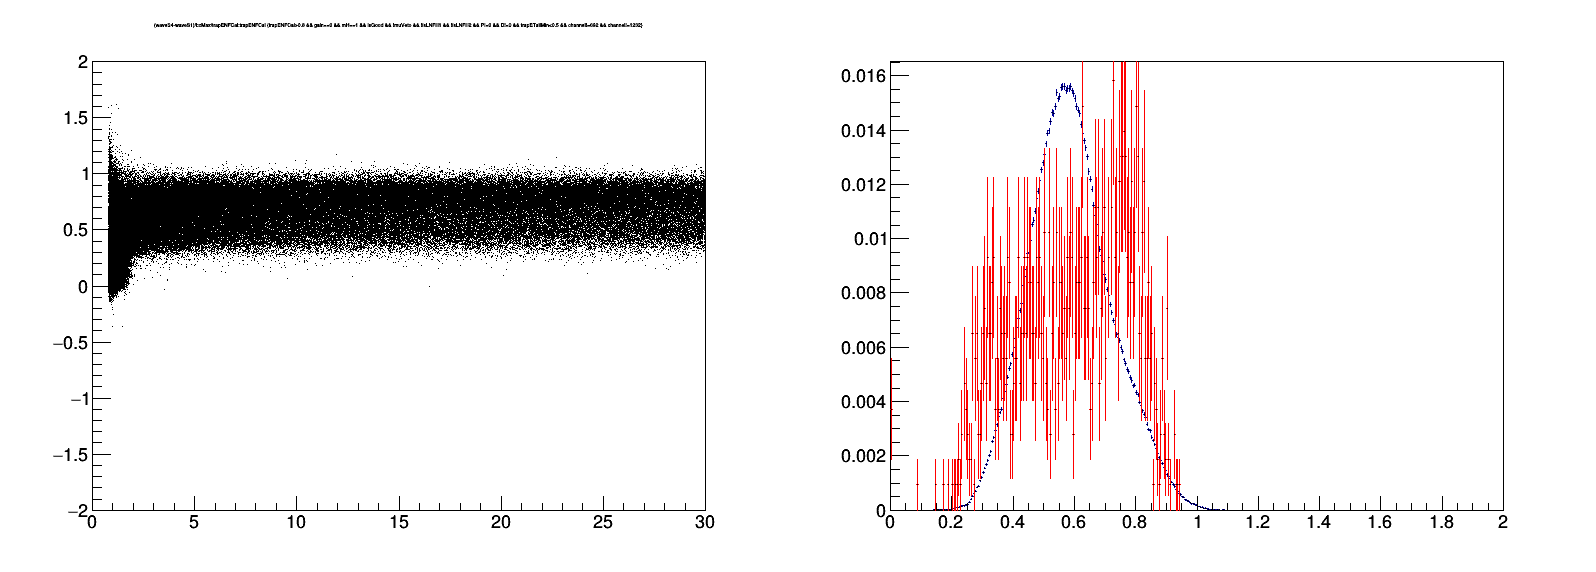

In [10]:
ds = 5
bins, lower, upper = 400,0,2
f1 = ROOT.TFile("~/project/lat/latSkimDS%d_0_0.root"%ds)
theCut = f1.Get("theCut").GetTitle()
calib = ROOT.TChain("skimTree"); calib.Add("~/project/cal-lat/latSkimDS%d*.root"%ds)
bgCut = "&& isNat && trapENFCal > 9.8 && trapENFCal < 10.8" # Integrating over 10.4 keV peak
bg = ROOT.TChain("skimTree"); bg.Add("~/project/lat/latSkimDS%d*.root"%ds)
c = ROOT.TCanvas("c","c",1600,600)
c.Divide(2,1)
c.cd(1) 

# make the raw spectrum
ROOT.gPad.SetLogy(0)
calib.Draw("(waveS4-waveS1)/bcMax/trapENFCal:trapENFCal>>h1(10,0,30,10,-2,2)",theCut)

c.cd(2)
ROOT.gPad.SetLogy(0)

h0 = ROOT.TH1D("h0","",bins,lower,upper)
h01 = ROOT.TH1D("h01","",bins,lower,upper)
calib.Project("h0","(waveS4-waveS1)/bcMax/trapENFCal",theCut+"&& trapENFCal > 5")
bg.Project("h01","(waveS4-waveS1)/bcMax/trapENFCal",theCut+bgCut)
h0.Scale(1/h0.Integral()); h0.Draw()
h01.Scale(1/h01.Integral()); h01.SetLineColor(ROOT.kRed); h01.Draw("SAME")
c.Draw()

# Direct integral method
raw01,raw05,raw10,raw15,raw90,raw95,raw99 = GetIntegralPoints(h0)
bg01,bg05,bg10,bg15,bg90,bg95,bg99 = GetIntegralPoints(h01)
print "raw 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (raw01,raw05,raw10,raw15,raw90,raw95,raw99)
print "bg 01: %.3f  05: %.3f  10: %.3f 15: %.3f  90: %.3f  95: %.3f  99: %.3f" % (bg01,bg05,bg10,bg15,bg90,bg95,bg99)

fig = plt.figure(figsize=(7,6),facecolor='w')
x_h0, y_h0 = npTH1D(h0)
int_h0 = integFunc(y_h0)
plt.plot(x_h0,int_h0,'b')
x1_h0, y1_h0 = npTH1D(h01)
int1_h0 = integFunc(y1_h0)
plt.plot(x1_h0,int1_h0,'red')
# plt.axvline(raw95,color='red')
# plt.axvline(raw99,color='green')
# plt.axvline(raw01,color='green')
# plt.axvline(raw05,color='red')
plt.show()